In [131]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
import torch.functional as F
import numpy as np
import pandas as pd
import time
import random
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from IPython import display

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [10]:
!pip install fastparquet
!pip install selfies
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 73.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.7/206.7 kB 20.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.2 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=417e65930b67930d3d9b6ee44053f7bd180545889d52cb16c597d802a35380b8
  Stored in directory: /root

# Data prep

In [132]:
#somehow load two parquet files into coxd ale to jeszcze lab - drive?
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [133]:
!ls '/content/drive/My Drive/GRU_data'

250k_klek.csv	  combined_klek.parquet
250k_selfies.csv  combined_selfies.parquet


In [ ]:
import selfies as sf
data = pd.read_parquet('/content/drive/My Drive/GRU_data/combined_selfies.parquet')
alphabet = sf.get_alphabet_from_selfies(data.selfies)
#alphabet.add("[nop]") # [nop] is a special padding symbol
alphabet.add("[start]")
alphabet.add("[end]")
alphabet.add("[nop]")
alphabet = list(sorted(alphabet))
pad_to_len = max(sf.len_selfies(s) for s in data.selfies) + 10
print("Pad to len:", pad_to_len)
symbol_to_idx = {s: i for i, s in enumerate(alphabet)}
idx2char = {i: s for i, s in enumerate(alphabet)}

In [ ]:
len(alphabet)

In [ ]:
import re
class SELFIESVectorizer:
    def __init__(self, alphabet, pad_to_len=None):
        self.alphabet = alphabet
        self.char2idx = {s: i for i, s in enumerate(alphabet)}
        self.idx2char = {i: s for i, s in enumerate(alphabet)}
        self.pad_to_len = pad_to_len
    def vectorize(self, selfie, no_special=False):
        ''' Vectorize a list of SMILES strings to a numpy array of shape (len(smiles), embed, len(charset))'''
        if no_special:
            splited = self.split_selfi(selfie)
        elif self.pad_to_len is None:
            splited = ['[start]'] + self.split_selfi(selfie) + ['[end]']
        else:
            splited = ['[start]'] + self.split_selfi(selfie) + ['[end]'] + ['[nop]'] * (self.pad_to_len - len(self.split_selfi(selfie)) - 2)
        X = np.zeros((len(splited), len(self.alphabet)))
        for i in range(len(splited)):
            X[i, self.char2idx[splited[i]]] = 1
        return X
    def devectorize(self, ohe, remove_special=False):
        ''' Devectorize a numpy array of shape (len(smiles), embed, len(charset)) to a list of SMILES strings'''
        selfie_str = ''
        for j in range(ohe.shape[0]):
            idx = np.argmax(ohe[j, :])
            if remove_special and (self.idx2char[idx] == '[start]' or self.idx2char[idx] == '[end]'):
                continue
            selfie_str += self.idx2char[idx]
        return selfie_str
    def idxize(self, selfie, no_special=False):
        if no_special:
            splited = self.split_selfi(selfie)
        else:
            splited = ['[start]'] + self.split_selfi(selfie) + ['[end]'] + ['[nop]'] * (self.pad_to_len - len(self.split_selfi(selfie)) - 2)
        return np.array([self.char2idx[s] for s in splited])
    def deidxize(self, idx):
        return "".join([self.idx2char[i] for i in idx])
    def split_selfi(self, selfie):
        pattern = r'(\[[^\[\]]*\])'
        return re.findall(pattern, selfie)

In [14]:
vectorizer = SELFIESVectorizer(alphabet, pad_to_len=pad_to_len)

In [15]:
test_selfie = data.selfies[0]
ohe = vectorizer.vectorize(test_selfie)
print("SELFIE:", test_selfie)
print("OHE:", ohe)
print("Devectorized:", vectorizer.devectorize(ohe))

SELFIE: [C][C][=C][C][=C][Branch2][Ring1][=N][C][=Branch1][C][=O][N][C][=C][C][=C][Branch1][=C][S][=Branch1][C][=O][=Branch1][C][=O][N][=C][Branch1][C][N][N][C][=C][Ring1][=N][C][=C][Ring2][Ring1][=Branch1]
OHE: [[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
Devectorized: [start][C][C][=C][C][=C][Branch2][Ring1][=N][C][=Branch1][C][=O][N][C][=C][C][=C][Branch1][=C][S][=Branch1][C][=O][=Branch1][C][=O][N][=C][Branch1][C][N][N][C][=C][Ring1][=N][C][=C][Ring2][Ring1][=Branch1][end][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]


In [16]:
idx = vectorizer.idxize(test_selfie)
print("IDX:", idx)
print("Deidxized:", vectorizer.deidxize(idx))

IDX: [41 23 23  9 23  9 18 33 11 23  7 23 12 29 23  9 23  9 17  9 35  7 23 12
  7 23 12 29  9 17 23 29 29 23  9 33 11 23  9 34 33  7 39 40 40 40 40 40
 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40
 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40
 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40]
Deidxized: [start][C][C][=C][C][=C][Branch2][Ring1][=N][C][=Branch1][C][=O][N][C][=C][C][=C][Branch1][=C][S][=Branch1][C][=O][=Branch1][C][=O][N][=C][Branch1][C][N][N][C][=C][Ring1][=N][C][=C][Ring2][Ring1][=Branch1][end][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop][nop]


In [17]:
from torch.utils.data import Dataset, DataLoader

class GRUDataset(Dataset):
    def __init__(self, smiles_fp, selfies, vectorizer):
        self.smiles_fp = pd.read_csv(smiles_fp, sep=',', nrows=50000)
        self.selfies = pd.read_csv(selfies, nrows=500000)
        self.X = self.prepare_X(self.smiles_fp)
        self.X = np.array([self.reconstruct_fp(fp) for fp in self.X])
        self.y = self.prepare_y(self.selfies)
        self.vectorizer = vectorizer
    def __len__(self):
        return len(self.smiles_fp)
    def __getitem__(self, idx):
        raw_selfie = self.y[idx][0]
        vectorized_selfie = self.vectorizer.vectorize(raw_selfie)
        # esentially, we want to predict the next symbol in the SELFIE and offset the target by one makes teaching forcing implicit
        vectorized_selfie = vectorized_selfie[1:, :]
        return torch.from_numpy(self.X[idx]).float(), torch.from_numpy(vectorized_selfie).float()

    @staticmethod
    def prepare_X(smiles_fp):
        fps = smiles_fp.fps.apply(eval).apply(lambda x: np.array(x, dtype=int))
        return fps
    @staticmethod
    def prepare_y(selfies):
        return selfies.values
    @staticmethod
    def reconstruct_fp(fp, length=4860):
        fp_rec = np.zeros(length)
        fp_rec[fp] = 1
        return fp_rec

In [18]:
from torch.utils.data import Dataset, DataLoader
class GRUDatasetv2(Dataset):
    def __init__(self, smiles_fp, selfies, vectorizer):
        self.smiles_fp = pd.read_csv(smiles_fp, nrows=50000)
        self.selfies = pd.read_csv(selfies, nrows=50000)
        # self.X = self.prepare_X(self.smiles_fp)
        # self.X = np.array([self.reconstruct_fp(fp) for fp in self.X])
        self.selfies= self.prepare_y(self.selfies)
        self.vectorizer = vectorizer
    def __len__(self):
        return len(self.smiles_fp)
    def __getitem__(self, idx):
        raw_selfie = self.selfies[idx][0]
        vectorized_selfie = self.vectorizer.idxize(raw_selfie)
        # esentially, we want to predict the next symbol in the SELFIE and offset the target by one makes teaching forcing implicit
        vectorized_selfie = vectorized_selfie
        raw_X = self.smiles_fp.fps[idx]
        X = np.array(eval(raw_X), dtype=int)
        X_reconstructed = self.reconstruct_fp(X)

        return torch.from_numpy(X_reconstructed).float(), torch.from_numpy(vectorized_selfie).long()

    @staticmethod
    def prepare_X(smiles_fp):
        fps = smiles_fp.fps.apply(eval).apply(lambda x: np.array(x, dtype=int))
        return fps
    @staticmethod
    def prepare_y(selfies):
        return selfies.values
    @staticmethod
    def reconstruct_fp(fp, length=4860):
        fp_rec = np.zeros(length)
        fp_rec[fp] = 1
        return fp_rec

In [19]:
dataset = GRUDatasetv2('/content/drive/My Drive/GRU_data/250k_klek.csv', '/content/drive/My Drive/GRU_data/250k_selfies.csv', vectorizer)
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [20]:
train_dataset[1]

(tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([41, 23, 29, 35,  7, 23, 12,  7, 23, 12, 23,  9, 23,  9, 18, 33, 34, 23,
         23, 23, 11, 23, 17,  8, 23,  9, 23,  9, 29, 11, 33,  7, 11, 31, 33, 31,
         23,  9, 34, 33, 33, 39, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
         40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
         40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
         40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
         40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40]))

In [21]:
print("Dataset size:", len(dataset))
print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))

Dataset size: 50000
Train size: 45000
Test size: 5000


In [117]:
batch_size = 64
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, drop_last=True)
src, trg = next(iter(train_loader))
trg.shape

torch.Size([64, 119])

In [23]:
dataset[0]

(tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([41, 23, 23, 17, 23, 23, 17, 23, 23, 23,  9, 23,  9, 31, 23,  9, 17, 35,
         23, 23,  7, 23, 12, 29, 23,  9, 23,  9, 23,  9, 33,  7, 25, 23, 33, 35,
          9, 34, 33, 34, 39, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
         40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
         40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
         40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
         40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40]))

# NN architecture

In [123]:
class EncoderNet(nn.Module):
    def __init__(self, fp_size, encoding_size):
        super(EncoderNet, self).__init__()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(fp_size, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, encoding_size)
    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        out = self.relu(self.fc3(out))
        out = self.relu(self.fc4(out))
        out = self.relu(self.fc5(out))
        return out


class DecoderNet(nn.Module):
    def __init__(self, dictionary_size, encoding_size, hidden_size, num_layers, drop_prob):
        super(DecoderNet, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.drop_prob = drop_prob
        self.embedding = nn.Embedding(dictionary_size, encoding_size)
        self.gru = nn.GRU(encoding_size, hidden_size, num_layers, dropout=drop_prob, batch_first=True)
        self.fc = nn.Linear(hidden_size, dictionary_size)
        self.max_len = vectorizer.pad_to_len

    def forward(self, input, hidden):
        prediction, hidden = self.gru(input, hidden)
        prediction = self.fc(prediction)
        return prediction, hidden
    
class Autoencoder(nn.Module):
    def __init__(self, input_size=4860, 
                 encoding_size=128, 
                 dictionary_size=len(alphabet), 
                 hidden_size=128, 
                 num_layers=2, 
                 teacher_forcing_ratio=0.5,
                 drop_prob=0.2):
        super(Autoencoder, self).__init__()
        self.encoder = EncoderNet(input_size, encoding_size)
        self.num_layers = num_layers  
        self.hidden_size = hidden_size
        self.encoding_size = encoding_size
        self.decoder = DecoderNet(dictionary_size, encoding_size, hidden_size, num_layers, drop_prob)
        self.teacher_forcing_ratio = teacher_forcing_ratio

    def forward(self, src, trg, teacher_forcing_ratio=None):
        teacher_forcing_ratio = self.teacher_forcing_ratio if teacher_forcing_ratio is None else teacher_forcing_ratio
        # if in evaluation mode we don't use teacher forcing
        if not self.training:
            teacher_forcing_ratio = 0
        batch_size = src.shape[0]
        trg_vocab_size = self.decoder.fc.out_features
        outputs = []
        hidden = torch.zeros(self.num_layers, src.shape[0], self.hidden_size)
        input = self.encoder(src).unsqueeze(1)
        for t in range(1, self.encoding_size):
            input[:, :, t]
            print(f'Input shape: {input.shape}')
            print(f'Hidden shape: {hidden.shape}')
            output, hidden = self.decoder(input, hidden)
            outputs.append(output)
            teacher_force = 0 #random.random() < teacher_forcing_ratio
            top1 = torch.argmax(output, dim=2)
        outputs = torch.cat(outputs, dim=1)
        return outputs

In [64]:
encoder = EncoderNet(4860, 128).to(device)
decoder = DecoderNet(dictionary_size=len(alphabet), 
                     emb_size=128, 
                     hidden_size=128, 
                     num_layers=2, 
                     drop_prob=0.2).to(device)
test_batch = next(iter(train_loader))[0].to(device)
test_batch.shape

torch.Size([64, 4860])

In [82]:
print(f'Test batch shape: {test_batch.shape}')
encoded = encoder(test_batch)
print(f'Encoded shape: {encoded.shape}')

Test batch shape: torch.Size([64, 4860])
Encoded shape: torch.Size([64, 128])


In [66]:
start_token = vectorizer.idxize('[start]', no_special=True)
start_token = torch.from_numpy(start_token).long().to(device).unsqueeze(0)
start_token = start_token.repeat(test_batch.shape[0], 1)
print(f'Start token shape: {start_token.shape}')
#print(f'Start token: {start_token}')

Start token shape: torch.Size([64, 1])


In [67]:
encoded = encoded.unsqueeze(1)
encoded.shape

torch.Size([64, 1, 128])

In [107]:
hidden = torch.zeros(2, 64, 128).to(device)
decoded, hidden = decoder(encoded, hidden)
print(f'Encoded shape: {encoded.shape}')
print(f'Decoded shape: {decoded.shape}')
print(f'Hidden shape: {hidden.shape}')

RuntimeError: ignored

In [124]:
model = Autoencoder().to(device)
test_src = next(iter(train_loader))[0].to(device)
test_trg = next(iter(train_loader))[1].to(device)
test_src.shape

torch.Size([64, 4860])

In [125]:
outputs = model(src=test_src, trg=test_trg)
print(f'Outputs shape: {outputs.shape}')

Input shape: torch.Size([64, 1, 128])
Hidden shape: torch.Size([2, 64, 128])
Input shape: torch.Size([64, 1, 128])
Hidden shape: torch.Size([2, 64, 128])
Input shape: torch.Size([64, 1, 128])
Hidden shape: torch.Size([2, 64, 128])
Input shape: torch.Size([64, 1, 128])
Hidden shape: torch.Size([2, 64, 128])
Input shape: torch.Size([64, 1, 128])
Hidden shape: torch.Size([2, 64, 128])
Input shape: torch.Size([64, 1, 128])
Hidden shape: torch.Size([2, 64, 128])
Input shape: torch.Size([64, 1, 128])
Hidden shape: torch.Size([2, 64, 128])
Input shape: torch.Size([64, 1, 128])
Hidden shape: torch.Size([2, 64, 128])
Input shape: torch.Size([64, 1, 128])
Hidden shape: torch.Size([2, 64, 128])
Input shape: torch.Size([64, 1, 128])
Hidden shape: torch.Size([2, 64, 128])
Input shape: torch.Size([64, 1, 128])
Hidden shape: torch.Size([2, 64, 128])
Input shape: torch.Size([64, 1, 128])
Hidden shape: torch.Size([2, 64, 128])
Input shape: torch.Size([64, 1, 128])
Hidden shape: torch.Size([2, 64, 128])

In [126]:
outputs_fixed = outputs

In [127]:
# get first output from batch
output = outputs_fixed[0]
print(f'Output shape: {output.shape}')
print(f'Output: {torch.argmax(output, dim=1)}')

Output shape: torch.Size([127, 42])
Output: tensor([ 6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6, 31, 31, 31, 31,  6, 31,
        31,  6,  6, 31,  6,  6,  6, 31,  6,  6,  6,  6, 31, 31, 31,  6, 31,  6,
        31, 31, 31, 31, 31, 31, 31,  6, 31,  6,  6,  6,  6,  6, 31,  6,  6,  6,
        31,  6,  6,  6,  6,  6,  6,  6, 31,  6,  6, 31, 31,  6, 31,  6, 31, 31,
        31,  6,  6,  6,  6,  6,  6, 31,  6, 31,  6,  6,  6, 31,  6,  6,  6,  6,
        31, 31,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6, 31,  6, 31, 31, 31, 31, 31,  6, 31, 31, 31,  6,  6,  6,  6,  6,
         6])


# Training

In [128]:
def train_epoch(autoencoder, dataloader, learning_rate):
    autoencoder.train()
    criterion = nn.CrossEntropyLoss(ignore_index=vectorizer.char2idx['[nop]'])
    optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
    epoch_loss = 0
    for batch_idx, (src, trg) in enumerate(tqdm(dataloader)):
        src = src.to(device)
        trg = trg.to(device)
        optimizer.zero_grad()
        output = autoencoder(src, trg)
        trg = trg[:, 1:]
        output = output.permute(0, 2, 1)
        loss = criterion(output, trg)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(dataloader)

    return avg_loss
  
def evaluate(autoencoder, dataloader):
    autoencoder.eval()
    criterion = nn.CrossEntropyLoss(ignore_index=vectorizer.char2idx['[nop]'])
    epoch_loss = 0
    for batch_idx, (src, trg) in enumerate(dataloader):
        src = src.to(device)
        trg = trg.to(device)
        output = autoencoder(src, trg)
        trg = trg[:, 1:]
        output = output.permute(0, 2, 1)
        loss = criterion(output, trg)
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(dataloader)
    return avg_loss

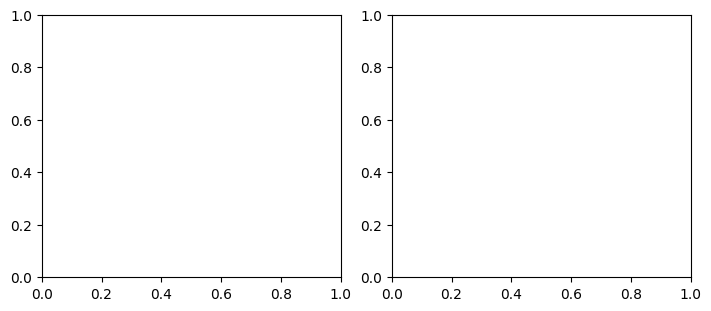

NameError: ignored

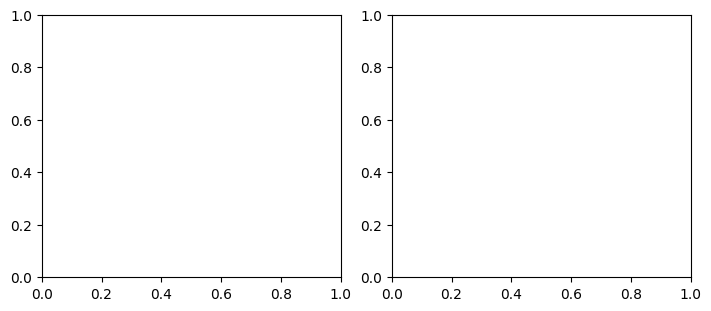

In [129]:
batch_size = 256
num_epochs = 10

epochs = []
train_losses = []
val_losses = []

fig, ax = plt.subplots(ncols=2, figsize=(7, 3), layout="constrained")
dh = display.display(fig, display_id=True)

for epoch in range(num_epochs):
  train_loss = train_epoch(model, train_loader, learning_rate=0.001)
  val_loss = evaluate(model, test_loader)
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  epochs.append(epoch+1)

  ax[0].clear()
  ax[0].plot(epochs, train_losses)
  ax[0].set_title('training loss')
  ax[0].set_xlabel('epoch')
  ax[0].set_ylabel('CrossEntropy')
  ax[1].clear()
  ax[1].plot(epochs, val_losses)
  ax[1].set_title('validation loss')
  ax[1].set_xlabel('epoch')
  ax[1].set_ylabel('CrossEntropy')
  dh.update(fig)
plt.close()

In [ ]:
# save model just in case
#torch.save(model.state_dict(), './GRU_data/test1.pt')

In [ ]:
#loaded_model = Autoencoder(4860, 300, 300, 42, 2, 0.0).to(device)
#loaded_model.load_state_dict(torch.load('./GRU_data/model_h300_e500_teacher_forcing.pt'))

In [ ]:
x, y = next(iter(test_loader))
x = x.to(device)
x.size()

In [ ]:
encoded, decoded = loaded_model(x)

# GRU output to SELFIES

In [ ]:
decoded_indices = torch.argmax(decoded.cpu(), dim=2)
decoded_indices = decoded_indices.numpy()

In [ ]:
# set largers value to 1 and others to 0
decoded_indices = torch.argmax(decoded.cpu(), dim=2)
decoded_indices = decoded_indices.numpy()
selfies_out = []
for i, original in zip(decoded_indices, y):
    vectorized = []
    #print(f'Decoded: {i}')
    #convert to one-hot
    for number in i:
        v = np.zeros(42)
        v[number] = 1
        vectorized.append(v)
    vectorized = np.array(vectorized)
    selfies_out.append(vectorizer.devectorize(vectorized, remove_special=True))
    print(f'Original: {vectorizer.devectorize(original.cpu().numpy())} \n')
    print(f'Decoded:  {vectorizer.devectorize(vectorized)}')
    print('------------------')

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw

smiles = []
for selfie in selfies_out:
    smile = sf.decoder(selfie, attribute=False)
    smiles.append(smile)

ms = []
for smile in smiles:
    ms.append(Chem.MolFromSmiles(smile))
Draw.MolToImage(ms[5], size=(800, 800), kekulize=True)